<html> <h1 style="font-style:bold; color:blue;"> Machine Learning in Finance </h1> </html>

<html> <h1 style="font-style:italic; color:blue;"> Week-5 </h1> </html>

#### More Advanced Trading Practices

## Forex EUR/USD price forecasting

#### It is a training example of forecasting the EUR/USD Forex next tick prices

#### ONE-DIMENSIONAL Convolutional Neural Network used
#### Tick Data with Dukastcopy Bank (https://www.dukascopy.com/swiss/english/marketwatch/historical/)

#### !! Please Note, that this notebook is a hands-on tutorial on Keras. Actual predicting stock and Forex prices is a really challenging and complex task that requires tremendous effort, especially at higher frequencies, such as ticks used in this practical

#### The Aim: According to the dynamics of TICK PRICES and VOLUME Forex EUR/USD to forecast the price of the next tick
#### We use a substantially refined and ALREADY normalised *.csv file based on raw data from the Dukastcopy repository.

#### Price, volume, and time intervals between ticks have been normalised previously because this process requires a high computer processing time.
#### Price normalisation principals: subtract the minimum and divide by the maximum price among 50 ticks that include this tick. 
#### Normalisation of volumes: based on a maximum of 10 lots (the main number of lots). The volume of more than 10  lots is equated to 10 lots (those to 1 after normalisation).
##### We normalised intervals between ticks: based on a maximum of 20,000 milliseconds (20 seconds) (the main number of intervals). The interval of over 20 seconds is equated to 20 seconds (those to 1 after normalisation).


______________________________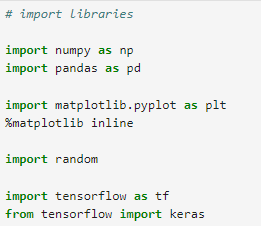

In [1]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import random

import tensorflow as tf
import keras

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

____________________________

In [2]:
print(tf.__version__)

2.19.0


_________________________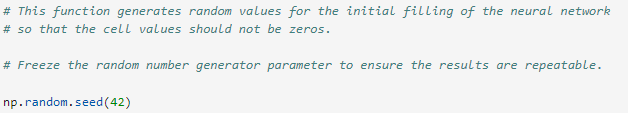

In [3]:
np.random.seed(42)

### Data 
#### We use a substantially refined and ALREADY normalised *.csv file based on raw data from the Dukastcopy repository.

_____________________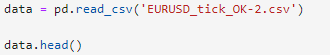

In [4]:
data = pd.read_csv('EURUSD_tick_OK-2.csv')

In [5]:
data.head()

,Vol_Ask_N,Ask_N_200_3,DateDelta1_N,Bid_N_200_3,Vol_Bid_N
0,0.176,0.636364,0.01655,0.515152,0.100
1,0.364,0.606061,0.02750,0.454545,0.420
2,0.100,0.575758,0.09770,0.454545,0.187
3,0.100,0.151515,0.01590,0.121212,0.100
4,0.270,0.212121,0.01040,0.060606,0.214


____________________

In [6]:
data.tail()

,Vol_Ask_N,Ask_N_200_3,DateDelta1_N,Bid_N_200_3,Vol_Bid_N
1099995,0.100,0.705357,0.01060,0.687500,0.195
1099996,0.100,0.758929,0.01630,0.741071,0.244
1099997,0.100,0.776786,0.00260,0.750000,0.382
1099998,0.461,0.794643,0.01045,0.758929,0.393
1099999,0.536,0.794643,0.00260,0.758929,0.664


_________________________________________

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100000 entries, 0 to 1099999
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Vol_Ask_N     1100000 non-null  float64
 1   Ask_N_200_3   1100000 non-null  float64
 2   DateDelta1_N  1100000 non-null  float64
 3   Bid_N_200_3   1100000 non-null  float64
 4   Vol_Bid_N     1100000 non-null  float64
dtypes: float64(5)
memory usage: 42.0 MB


In [8]:
# This dataset has already been normalised inside 50 tick windows and prepared for training.
# The data consists of normalised Ask prices (offer) and Bid (demand) and 
# the corresponding Volumes of transactions at Ask and Bid prices.
# A sequence of time intervals between adjacent ticks has been added as a parameter, 
# which contains critical information about the behaviour of market participants such as buyers and sellers.

____________________________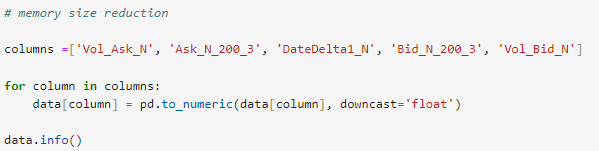

In [9]:
# memory size reduction

columns =['Vol_Ask_N', 'Ask_N_200_3', 'DateDelta1_N', 'Bid_N_200_3', 'Vol_Bid_N']

for column in columns:
    data[column] = pd.to_numeric(data[column], downcast='float')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100000 entries, 0 to 1099999
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Vol_Ask_N     1100000 non-null  float32
 1   Ask_N_200_3   1100000 non-null  float32
 2   DateDelta1_N  1100000 non-null  float32
 3   Bid_N_200_3   1100000 non-null  float32
 4   Vol_Bid_N     1100000 non-null  float32
dtypes: float32(5)
memory usage: 21.0 MB


_____________________________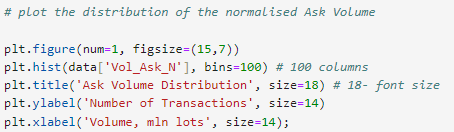

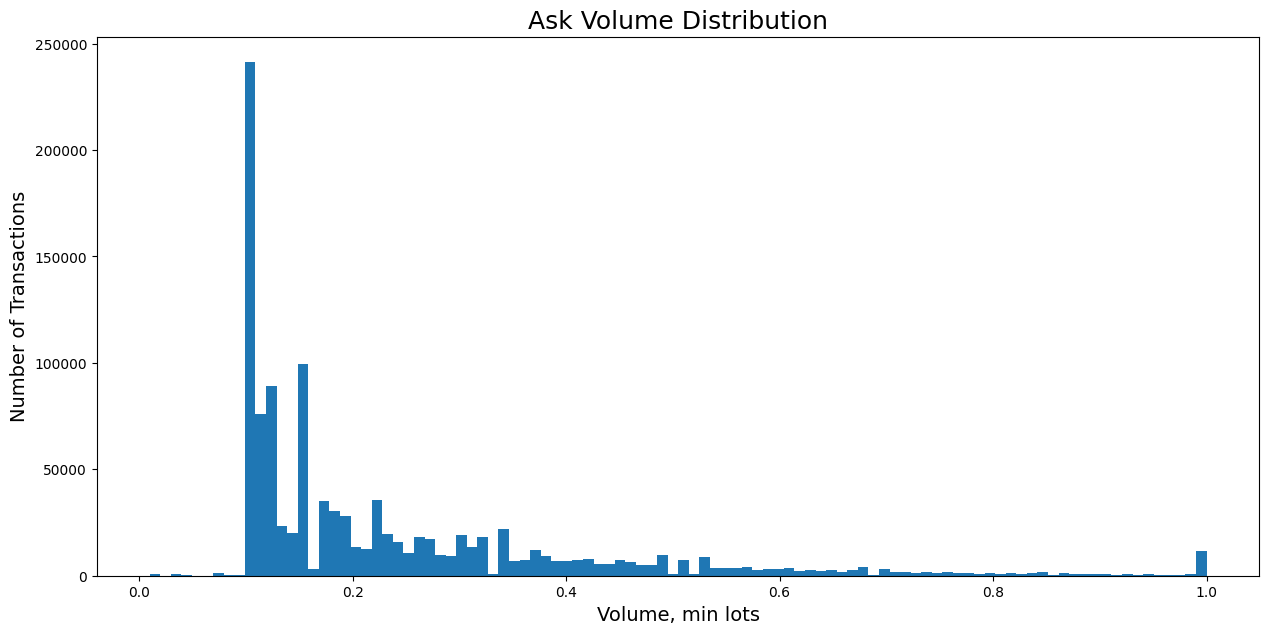

In [10]:
# plot the distribution of the normalised Ask Volume

plt.figure(num=1, figsize=(15,7))
plt.hist(data['Vol_Ask_N'], bins=100)
plt.title('Ask Volume Distribution', size=18)
plt.ylabel('Number of Transactions', size=14)
plt.xlabel('Volume, min lots', size=14);

In [11]:
# Explain the above distribution by writing a couple of sentences.

___________________________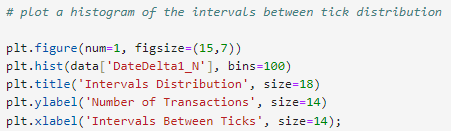

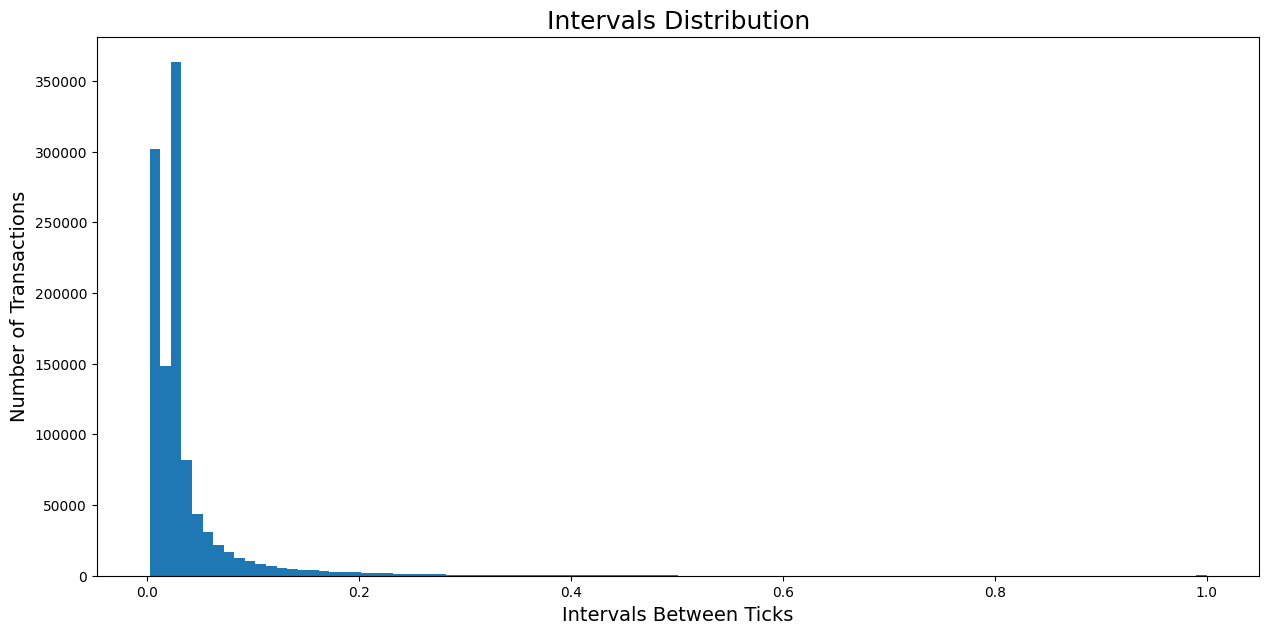

In [12]:
# plot a histogram of the intervals between tick distribution

plt.figure(num=1, figsize=(15,7))
plt.hist(data['DateDelta1_N'], bins=100)
plt.title('Intervals Distribution', size=18)
plt.ylabel('Number of Transactions', size=14)
plt.xlabel('Intervals Between Ticks', size=14);

In [13]:
# Explain the above distribution by writing a couple of sentences.

##### Create NumPy 

In [14]:
# We will analyse only part of the dataset since training the neural network with 
# an entire dataset would require massive computer power.

# n_small = 250,000 ticks, which equals around 1 week.

# We will create a three-dimensional data tensor: [(n_small-N + 1), N, 5] and 
# a two-dimensional array of answers [(n_small-N + 1), N] with a tick price-shifted one tick up.

# N=50 is the number of ticks for analysis at each step; those are looking backwards from the current moment.

# Then, you must delete the last sliced square subarray (50*5) since there is no price for the subsequent tick.

# Summary: the intermediate aim is to create
# 1. three-dimensional data tensor of sliced square subarrays [(n_small - N + 1 - 1), N, 5] and
# 2. two-dimensional array of answers Y[(n_small - N + 1 - 1), N] with a tick price shifted one tick up.

______________________________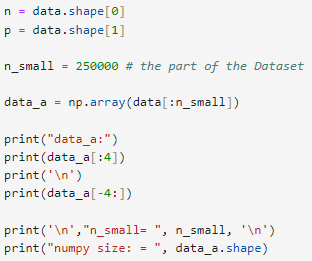

In [15]:
n = data.shape[0]
p = data.shape[1]

n_small = 250000

data_a = np.array(data[:n_small])

print("data_a:")
print(data_a[:4])
print('\n')
print(data_a[-4:])

print('\n','n_small= ", n_small, \n')
print("numpy size: = ", data_a.shape)

data_a:
[[0.176      0.6363636  0.01655    0.5151515  0.1       ]
 [0.364      0.6060606  0.0275     0.45454547 0.42      ]
 [0.1        0.57575756 0.0977     0.45454547 0.187     ]
 [0.1        0.15151516 0.0159     0.12121212 0.1       ]]


[[0.45       0.53424656 0.01085    0.46575344 0.345     ]
 [0.1        0.5068493  0.028      0.46575344 0.195     ]
 [0.1        0.5068493  0.0377     0.47945204 0.1       ]
 [0.1        0.5068493  0.03505    0.46575344 0.12      ]]

 n_small= ", n_small, 

numpy size: =  (250000, 5)


____________________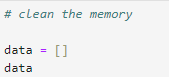

In [16]:
data = []

In [17]:
data

[]

##### Final aim: predicting the Bid and Ask prices of the next tick in FOREX EURUSD. 

_________________________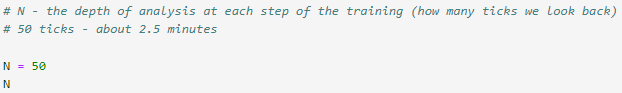

In [18]:
N = 50

In [19]:
N

50

________________________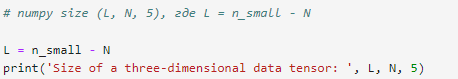

In [20]:
# numpy size (L, N, 5), z∂e L = n_small - N

L = n_small - N
print('Size of a three-dimensional data tensor: ', L, N, 5)

Size of a three-dimensional data tensor:  249950 50 5


In [21]:
# create zeros tensors with 'float32' for reducing calculations

_____________________________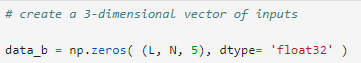

In [22]:
# create a 3-dimensional vector of inputs

data_b = np.zeros((L, N, 5), dtype='float32')

____________________________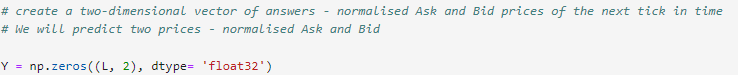

In [23]:
# create a two-dimensional vector of answers - normalised Ask and Bid prices of the next tick in time

Y = np.zeros((1, 2), dtype='float32')

__________________________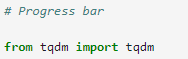

In [24]:
from tqdm import tqdm

___________________________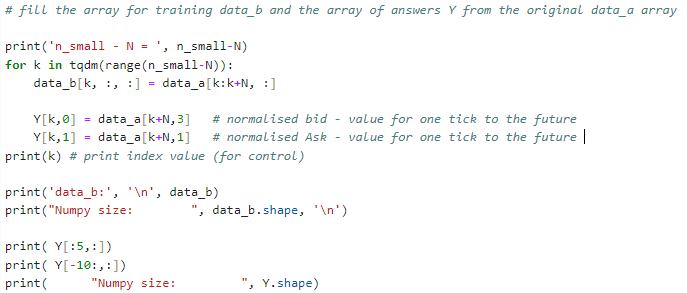

In [25]:
# First initialize Y with the correct size (L rows, 2 columns)
Y = np.zeros((L, 2), dtype='float32')

# Then run the loop
print('n_small - N = ', n_small-N)
for k in tqdm(range(n_small-N)):
    data_b[k, :, :] = data_a[k:k+N, :]
    Y[k,0] = data_a[k+N, 3]  # normalised bid
    Y[k,1] = data_a[k+N, 1]  # normalised Ask
print(k)

print('data_b:\n', data_b)
print("Numpy size: ", data_b.shape, '\n')

print(Y[:5,:])
print(Y[-10:,:])
print("Numpy size: ", Y.shape)

n_small - N =  249950


100%|██████████| 249950/249950 [00:00<00:00, 537389.49it/s]

249949
data_b:
 [[[0.176      0.6363636  0.01655    0.5151515  0.1       ]
  [0.364      0.6060606  0.0275     0.45454547 0.42      ]
  [0.1        0.57575756 0.0977     0.45454547 0.187     ]
  ...
  [0.232      0.45454547 0.2092     0.36363637 0.11      ]
  [0.1        0.42424244 0.2085     0.36363637 0.12      ]
  [0.102      0.45454547 0.0284     0.36363637 0.232     ]]

 [[0.364      0.6060606  0.0275     0.45454547 0.42      ]
  [0.1        0.57575756 0.0977     0.45454547 0.187     ]
  [0.1        0.15151516 0.0159     0.12121212 0.1       ]
  ...
  [0.1        0.42424244 0.2085     0.36363637 0.12      ]
  [0.102      0.45454547 0.0284     0.36363637 0.232     ]
  [0.125      0.45454547 0.2103     0.3939394  0.11      ]]

 [[0.1        0.57575756 0.0977     0.45454547 0.187     ]
  [0.1        0.15151516 0.0159     0.12121212 0.1       ]
  [0.27       0.21212122 0.0104     0.06060606 0.214     ]
  ...
  [0.102      0.45454547 0.0284     0.36363637 0.232     ]
  [0.125      0.45

______________________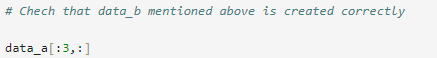

In [26]:
data_a[:3, :]

array([[0.176     , 0.6363636 , 0.01655   , 0.5151515 , 0.1       ],
       [0.364     , 0.6060606 , 0.0275    , 0.45454547, 0.42      ],
       [0.1       , 0.57575756, 0.0977    , 0.45454547, 0.187     ]],
      dtype=float32)

__________________________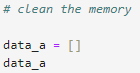

In [27]:
data_a = []

In [28]:
data_a

[]

#### Now just press 'CTRL' and 'ENTER' keys on the next cells.

In [29]:
# Control of the correctness of filling the array Y 
# (should show the normalised prices Bid and Ask one step ahead)

pp = random.randint(10, n_small-N-1)    # (any number before 249949) - just to look at the middle of data_b
print('random int = ', pp)

print('\t','data_b:', '\t\t\\t\t\t','Y:')
print('Bid ','\t\t\t','Ask', '\t\t\t','Bid','\t\t\t','Ask')

for i in range(7):
    print(data_b[pp+i,N-1,3], '\t\t', data_b[pp+i,N-1,1], '\t\t', Y[pp+i,0], '\t\t', Y[pp+i,1])

random int =  110090
	 data_b: 		\t		 Y:
Bid  			 Ask 			 Bid 			 Ask
0.6666667 		 0.7692308 		 0.64102566 		 0.71794873
0.64102566 		 0.71794873 		 0.64102566 		 0.6923077
0.64102566 		 0.6923077 		 0.5641026 		 0.64102566
0.5641026 		 0.64102566 		 0.5641026 		 0.64102566
0.5641026 		 0.64102566 		 0.5897436 		 0.64102566
0.5897436 		 0.64102566 		 0.53846157 		 0.5641026
0.53846157 		 0.5641026 		 0.51282054 		 0.5641026


In [30]:
# Each row of Y above must have prices of one tick to the future.
# You can run the previous cell several times to ensure the array Y is filled out correctly

#### Now just press 'CTRL' and 'ENTER' keys on the next cells.

In [31]:
# We print Min and Max of all normalised columns - All should be in the range [0; 1]
# Check that the matrixes are normalised and there are no values > 1

print('\t','\t Max \t\t Min')
mmx  = data_b[:,:,0].max()
mmn  = data_b[:,:,0].min()
print('Vol_Ask_N', '\t', mmx, '\t\t', mmn)
mmx  = data_b[:,:,1].max()
mmn  = data_b[:,:,1].min()
print('Ask_N_use', '\t', mmx, '\t\t', mmn)
mmx  = data_b[:,:,2].max()
mmn  = data_b[:,:,2].min()
print('DateDelta1_N', '\t', mmx, '\t\t', mmn)
mmx  = data_b[:,:,3].max()
mmn  = data_b[:,:,3].min()
print('Bid_N_use', '\t', mmx, '\t', mmn)
mmx  = data_b[:,:,4].max()
mmn  = data_b[:,:,4].min()
print('Vol_Bid_N', '\t', mmx, '\t\t', mmn)

	 	 Max 		 Min
Vol_Ask_N 	 1.0 		 0.01
Ask_N_use 	 1.0 		 0.004484305
DateDelta1_N 	 1.0 		 0.0025
Bid_N_use 	 0.995283 	 0.0
Vol_Bid_N 	 1.0 		 0.01


### Data for training and testing

________________________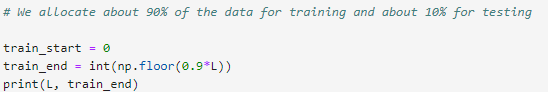

In [32]:
# We allocate about 90% of the data for training and about 10% for testing

train_start = 0  
train_end = int(np.floor(0.9*L))  
print(L, train_end)

249950 224955


_____________________________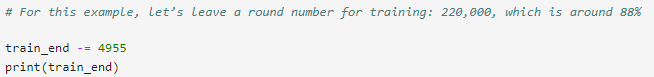

In [33]:
# For this example, let's leave a round number for training: 220,000, which is around 88%

train_end -= 4955
print(train_end)

220000


_________________________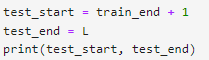

In [34]:
test_start = train_end + 1
test_end = L
print(test_start, test_end)

220001 249950


_______________

In [35]:
print(test_end - train_end)

29950


_________________________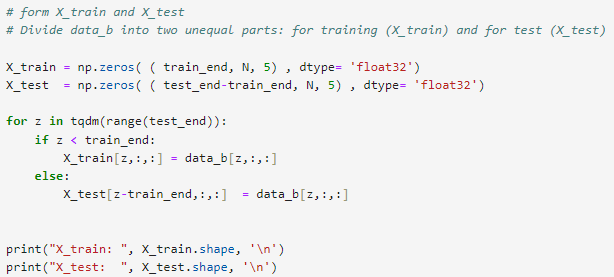

In [36]:
# form X_train and X_test

X_train = np.zeros( ( train_end, N, 5 ), dtype='float32')
X_test = np.zeros( ( test_end-train_end, N, 5 ), dtype='float32')

for z in tqdm(range(test_end)):
    if z < train_end:
        X_train[z,:,:] = data_b[z,:,:]
    else:
        X_test[z-train_end,:,:] = data_b[z,:,:]

print("X_train: ", X_train.shape, '\n')
print("X_test: ", X_test.shape, '\n')

100%|██████████| 249950/249950 [00:00<00:00, 843919.93it/s]

X_train:  (220000, 50, 5) 

X_test:  (29950, 50, 5) 



_______________________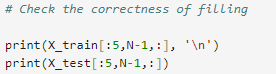

In [37]:
# Check the correctness of filling

print(X_train[:5,N-1,:], '\n')
print(X_test[:5,N-1,:])

[[0.102      0.45454547 0.0284     0.36363637 0.232     ]
 [0.125      0.45454547 0.2103     0.3939394  0.11      ]
 [0.1        0.45454547 0.02625    0.3939394  0.382     ]
 [0.27       0.4848485  0.0358     0.3939394  0.27      ]
 [0.262      0.4848485  0.04245    0.45454547 0.1       ]] 

[[0.145      0.76623374 0.03765    0.74025977 0.1       ]
 [0.12       0.76623374 0.0285     0.74025977 0.1       ]
 [0.107      0.76623374 0.02745    0.74025977 0.1       ]
 [0.12       0.76623374 0.069      0.71428573 0.525     ]
 [0.145      0.76623374 0.1029     0.74025977 0.1       ]]


#### Create the answer matrixes (outputs) for the training (y_train) and testing (y_test) 

____________________________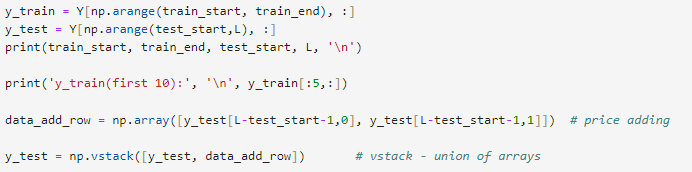

In [38]:
y_train = Y[np.arange(train_start, train_end), :]
y_test = Y[np.arange(test_start,L), :]
print(train_start, train_end, test_start, L, '\n')

print('y_train(first 10):', '\n', y_train[:5,:])

data_add_row = np.array([y_test[L-test_start-1,0], y_test[L-test_start-1,1]])

y_test = np.vstack([y_test, data_add_row])

0 220000 220001 249950 

y_train(first 10): 
 [[0.3939394  0.45454547]
 [0.3939394  0.45454547]
 [0.3939394  0.4848485 ]
 [0.45454547 0.4848485 ]
 [0.5151515  0.54545456]]


#### Final control

#### Now just press 'CTRL' and 'ENTER' keys on the next cells.

In [39]:
# print X_train, y_train, X_test и y_test

print('Data for training:')
print("X_train:")
print("Type: ", X_train.dtype,  type(X_train), "; Size: ", X_train.shape)

print("\n","y_train:")
print("Type: ", y_train.dtype,  type(y_train), "; Size: ", y_train.shape)

print('Data for testing:')
print("\n","X_test:")
print("Type: ", X_test.dtype, type(X_test), "; Size: ", X_test.shape)

print("\n","y_test:")
print("Type: ", y_test.dtype,  type(y_test), "; Size: ", y_test.shape)

Data for training:
X_train:
Type:  float32 <class 'numpy.ndarray'> ; Size:  (220000, 50, 5)

 y_train:
Type:  float32 <class 'numpy.ndarray'> ; Size:  (220000, 2)
Data for testing:

 X_test:
Type:  float32 <class 'numpy.ndarray'> ; Size:  (29950, 50, 5)

 y_test:
Type:  float32 <class 'numpy.ndarray'> ; Size:  (29950, 2)


### Convolutional Neural Network

#### Create CNN

__________________________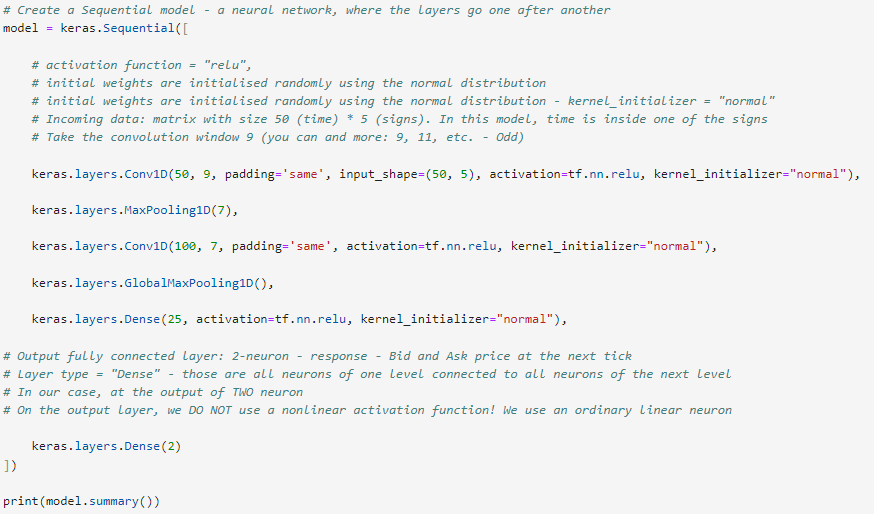

In [40]:
# Create a Sequential model
model = keras.Sequential([
    keras.layers.Conv1D(50, 9, padding='same', input_shape=(50, 5), activation=tf.nn.relu, kernel_initializer="normal"),
    keras.layers.MaxPooling1D(7),
    keras.layers.Conv1D(100, 7, padding='same', activation=tf.nn.relu, kernel_initializer="normal"),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(25, activation=tf.nn.relu, kernel_initializer="normal"),
    keras.layers.Dense(2)
])

print(model.summary())

c:\Users\Zain Faisal\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 50, 50)         │         2,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 100)         │        35,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,977 (156.16 KB)

 Trainable params: 39,977 (156.16 KB)

 Non-trainable params: 0 (0.00 B)

None


### Model compilation

________________________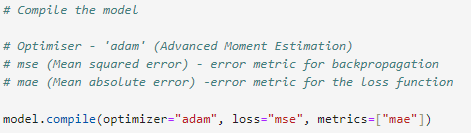

In [41]:
# Compile the model

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [42]:
#model.fit?

### Trainig CNN

________________________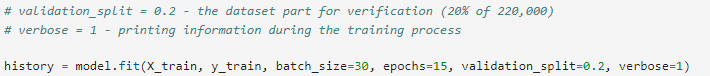

In [43]:
# validation_split = 0.2

history = model.fit(X_train, y_train, batch_size=30, epochs=15, validation_split=0.2, verbose=1)

Epoch 1/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - loss: 0.0059 - mae: 0.0369 - val_loss: 9.1873e-04 - val_mae: 0.0204
Epoch 2/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 7.5068e-04 - mae: 0.0187 - val_loss: 8.7538e-04 - val_mae: 0.0194
Epoch 3/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 7.3385e-04 - mae: 0.0183 - val_loss: 0.0011 - val_mae: 0.0231
Epoch 4/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - loss: 7.1885e-04 - mae: 0.0182 - val_loss: 8.6314e-04 - val_mae: 0.0194
Epoch 5/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 7.0950e-04 - mae: 0.0179 - val_loss: 8.8724e-04 - val_mae: 0.0201
Epoch 6/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 7.1869e-04 - mae: 0.0180 - val_loss: 8.2775e-04 - val_mae: 0.0185
Epoch 7/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - loss: 7.1863e-04 - mae: 0.0178 - val_loss: 8.9703e-04 - val_mae: 0.0201
Epoch 8/15
5867/5867 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - loss: 6.8964e-04 - mae: 0.0177 - val_loss: 8.546

### Evaluation

__________________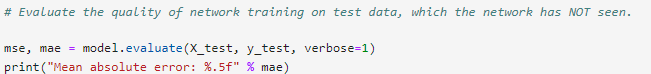

In [44]:
# Evaluate the quality of network training on test data

mse, mae = model.evaluate(X_test, y_test, verbose=1)
print("Mean absolute error: %.5f" % mae)

936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012 - mae: 0.0232
Mean absolute error: 0.02474


### Mean Absolute Error (MAE) graphs during training

#### Now just press 'CTRL' and 'ENTER' keys on the next cells.

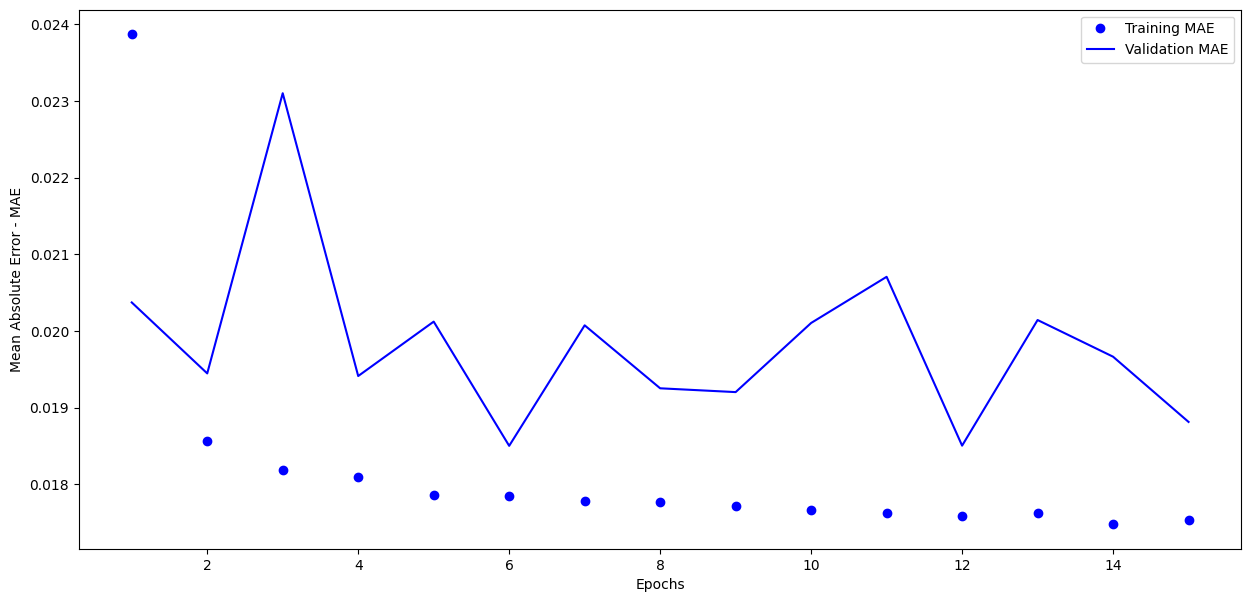

In [45]:
history_dict = history.history

mean_absolute_error_values = history_dict['mae']

val_mean_absolute_error_values = history_dict['val_mae']

epochs = range(1, len(mean_absolute_error_values) + 1)
plt.figure(num=1, figsize=(15,7))
plt.plot(epochs, mean_absolute_error_values, 'bo', label='Training MAE')
plt.plot(epochs, val_mean_absolute_error_values, 'b', label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error - MAE')
plt.legend()
plt.show()

### Normalised Price Chart

In [46]:
pred = model.predict(X_test)

936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


____________________________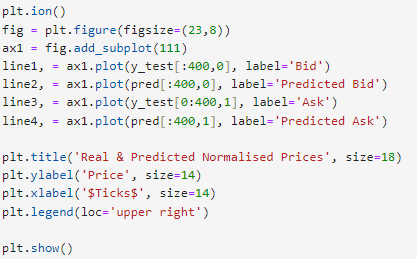

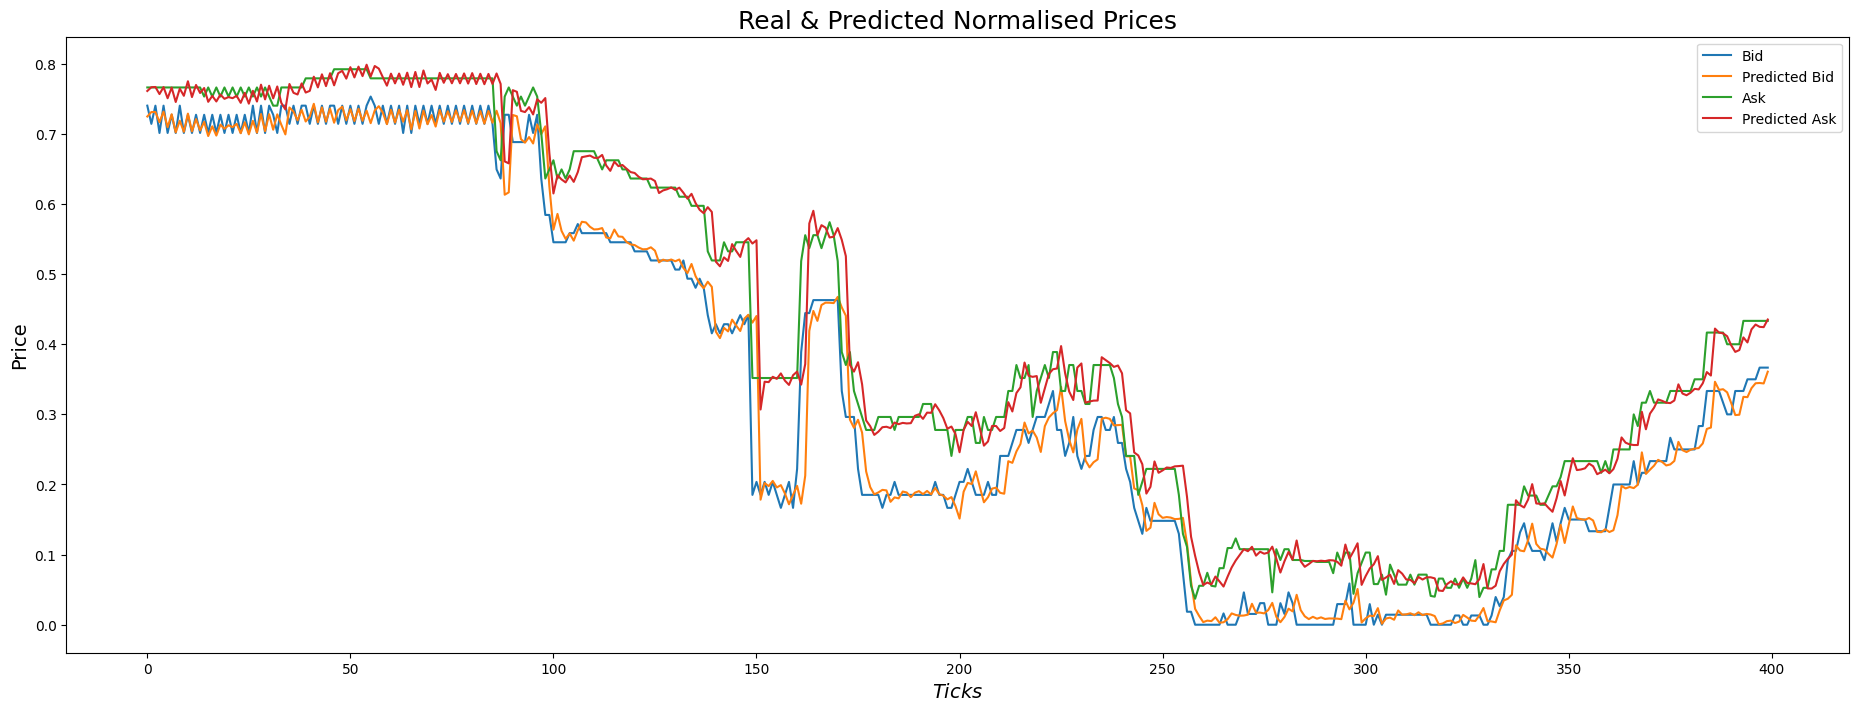

In [47]:
plt.ion()
fig = plt.figure(figsize=(23,8))
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test[:400,0], label='Bid')
line2, = ax1.plot(pred[:400,0], label='Predicted Bid')
line3, = ax1.plot(y_test[0:400,1], label='Ask')
line4, = ax1.plot(pred[:400,1], label='Predicted Ask')

plt.title('Real & Predicted Normalised Prices', size=18)
plt.ylabel('Price', size=14)
plt.xlabel('$Ticks$', size=14)
plt.legend(loc='upper right')

plt.show()

### Detailed Error Chart

#### Now just press 'CTRL' and 'ENTER' keys on the next cells.

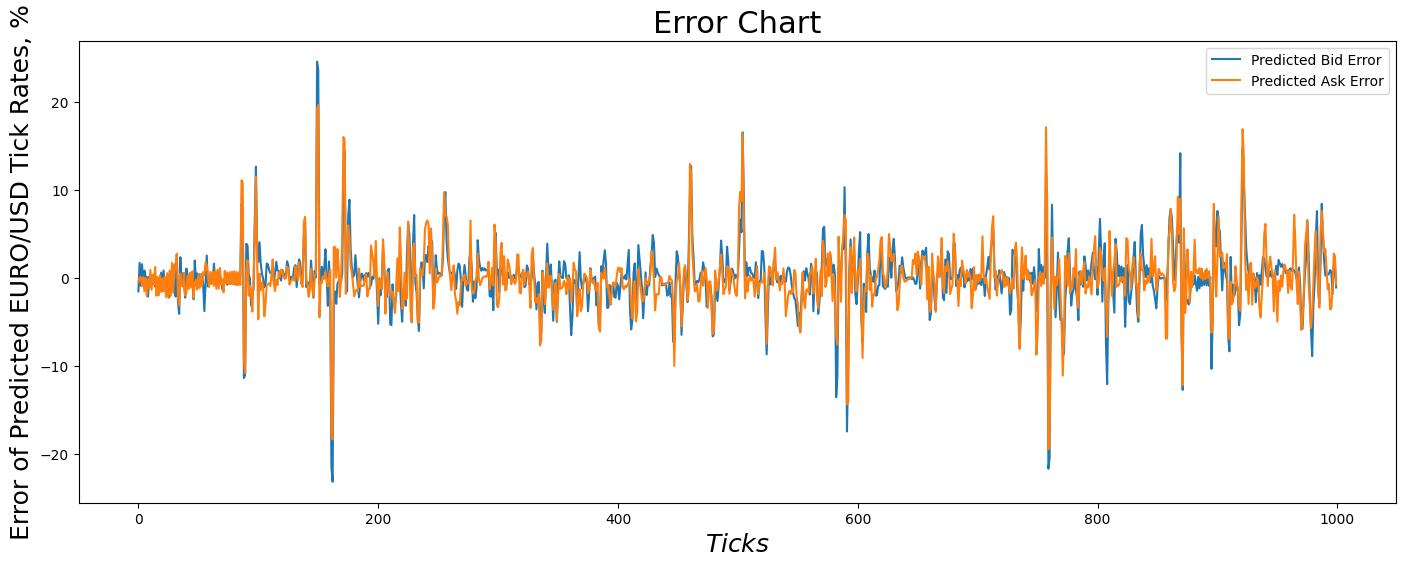

In [48]:
N1=0     # start
N2=1000   # end

plt.ion()
fig = plt.figure(figsize=(17,6))
ax1 = fig.add_subplot(111)

a = (pred[N1:N2,0]-y_test[N1:N2,0])*100
b = (pred[N1:N2,1]-y_test[N1:N2,1])*100

line1, = ax1.plot(a, label='Predicted Bid Error')
line2, = ax1.plot(b, label='Predicted Ask Error')

plt.title('Error Chart', size=22)
plt.ylabel('Error of Predicted EURO/USD Tick Rates, %', size=18)
plt.xlabel('$Ticks$', size=18)
plt.legend(loc='upper right') 

plt.show()

In [49]:
# explain the results by writing a few sentences

In [50]:
# Key Points:
# 1. Data Prep: Normalized 250k ticks of bid/ask/volumes, created 3D tensors (50-step windows) for sequence modeling
# 2. Model Design: CNN captures temporal patterns, Global Pooling condenses features, Dense layers predict next-tick prices
# 3. Training: 15 epochs on 220k samples (20% validation), Adam optimizer with MSE loss for regression
# 4. Results: MAE on unseen test data shows prediction accuracy, visualized via price vs predicted plots

# Lab Logbook Requirement:

<html> <h3 style="font-style:italic; color:blue;">
   
1) Modify the practical session CNN model by reducing the convolutional core size to 5.
2) Change the batch_size to 50.
3) Also, change the size of the number of epochs, which is calculated by the formula:

   Z + Y, if Z = 0

   10 + Y, if Z = 0 and Y is not 0

   10, if Z = Y = 0

   , where your SID is: XXXXXZY
5) Leave other parameters the same as in the practical session.
6) Compile the model.
6) Train your CNN with the same datasets and demonstrate the received test MAE.
Compare your MAE with the MAE of the CNN in the practical session.
7) Please only add a print-screen of your CNN architecture using model.summary() and the resulting MAE to your Lab Logbook.
    
</h3> </html>

<html> <h3 style="color:red;">
NOTE: DON'T FORGET TO SAVE AND BACK UP YOUR COMPLETED JUPYTER NOTEBOOK AND LAB LOGBOOK ON GITHUB OR ONEDRIVE.
</h3> </html>

In [51]:
from tensorflow import keras

# SID = 2424350
Z = 5
Y = 0

# Calculate epochs
if Z == 0 and Y != 0:
    epochs = 10 + Y
elif Z == Y == 0:
    epochs = 10
else:
    epochs = Z + Y  # 5 + 0 = 5

# Build modified CNN model with kernel size = 5
model = keras.Sequential([
    keras.layers.Conv1D(50, 5, padding='same', input_shape=(50, 5),
                        activation='relu', kernel_initializer="normal"),
    keras.layers.MaxPooling1D(7),
    keras.layers.Conv1D(100, 5, padding='same', activation='relu',
                        kernel_initializer="normal"),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(25, activation='relu', kernel_initializer="normal"),
    keras.layers.Dense(2)
])

# Compile model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train model
history = model.fit(X_train, y_train,
                    batch_size=50,
                    epochs=epochs,
                    validation_split=0.2,
                    verbose=1)

# Evaluate model
test_mse, test_mae = model.evaluate(X_test, y_test, verbose=0)

# Display summary and MAE
print("\nModified Model Summary for SID = 2424350:")
model.summary()
print(f"\nTest MAE for SID = 2424350: {test_mae:.4f}")

Epoch 1/5
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0109 - mae: 0.0484 - val_loss: 9.2030e-04 - val_mae: 0.0199
Epoch 2/5
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 7.4605e-04 - mae: 0.0187 - val_loss: 9.5083e-04 - val_mae: 0.0209
Epoch 3/5
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 7.1955e-04 - mae: 0.0182 - val_loss: 9.3722e-04 - val_mae: 0.0207
Epoch 4/5
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 7.2099e-04 - mae: 0.0180 - val_loss: 8.9820e-04 - val_mae: 0.0200
Epoch 5/5
3520/3520 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 7.1637e-04 - mae: 0.0179 - val_loss: 9.2369e-04 - val_mae: 0.0206

Modified Model Summary for SID = 2424350:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 50, 50)         │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 7, 100)         │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,933 (339.59 KB)

 Trainable params: 28,977 (113.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 57,956 (226.39 KB)


Test MAE for SID = 2424350: 0.0261
